# Multistep Neural Network for Learning Dynamics from Data

_Kevin Siswandi | May 2020_

In this notebook, I demonstrate how the Multistep Neural Network works to reconstruct the dynamics of 2-D Yeast Glycolysis. First of all, we need to make sure that `nodepy` and `tensorflow 2.x` are installed.

In [6]:
# Install nodepy in the current Jupyter kernel
import sys
!pip install --user nodepy

     |████████████████████████████████| 818 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 23.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 512 kB 30.3 MB/s eta 0:00:01
  Created wheel for mpmath: filename=mpmath-1.1.0-py3-none-any.whl size=532239 sha256=a9c79f2bd01b1ff242902366b413832cb65ce39804a82d00330064947994307a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e8/38/69/aa17553ad31f09ff5fa44c8a1a6c5b47e7c9261e9c7c16b9fb
Successfully built mpmath
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin/python -m pip install --upgrade pip' command.


In [3]:
# upgrade to tensorflow to 2
!pip install --user --upgrade tensorflow

     |████████████████████████████████| 516.2 MB 5.3 kB/s  eta 0:00:01     |█████████████                   | 211.4 MB 64.9 MB/s eta 0:00:05███████████████████████       | 401.9 MB 84.2 MB/s eta 0:00:02
     |████████████████████████████████| 63 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 104 kB 73.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 54.6 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.2 MB/s  eta 0:00:01
     |████████████████████████████████| 41 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 49.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 53.9 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 56.9 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 106 kB/s  eta 0:00:01
     |████████████████████████████████| 298 kB 55.3 MB/s eta 0:00:01
     |████████████████████████████████| 89

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
import nodepy.linear_multistep_method as lm
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import timeit

print(tf.__version__)
np.random.seed(1234)
tf.random.set_seed(1234)

2.2.0


Training is done to find the optimal parameters via minimising loss function:

$$ \arg \min_w \frac{1}{N - M + 1} \sum_{n = M}^{N} |\textbf{y}_n|^2 $$

where N is the number of data points and M multi steps. The linear difference/residual operator is defined as

$$ \textbf{y}_n = \sum_{n=0}^M \left(\alpha_m x_{n-m} + h \beta_m \textbf{f}(\textbf{x}_{n-m}) \right)$$

for $n=M,...,N$.

In [14]:
class lmmNet:
    """
    Implementation of the LMMNet
    version 1.2
    Fixes/updates:
        * number of hidden layer units is no longer hardcoded
        * fixed bug for wrong indexing of the coefficients in computing linear diff operator
        * loss printed every 100 epochs
        * optimizer now declared in constructor

    """
    
    def __init__(self, h, X, M, scheme, hidden_units):
        """
        Args:
        h -- step size
        X -- data array with shape S x N x D 
        M -- number of LMM steps
        scheme -- the LMM scheme (either AB, AM, or BDF)
        hidden_units -- number of units for the hidden layer
        
        """
        self.h = h
        self.X = X
        self.M = M # number of time steps
        
        # get the number of trajectories, discrete time instances, and number of feature dimensions
        self.S = X.shape[0]
        self.N = X.shape[1]
        self.D = X.shape[2]
        
        # load LMM coefficients from NodePy
        # https://nodepy.readthedocs.io/en/latest/
        if scheme == 'AB':
            coefs = lm.Adams_Bashforth(M)
        elif scheme == 'AM':
            coefs = lm.Adams_Moulton(M)
        elif scheme == 'BDF':
            coefs = lm.backward_difference_formula(M)
        else:
            raise Exception('Please choose a valid LMM scheme')
        
        self.alpha = np.float32(-coefs.alpha[::-1])
        self.beta = np.float32(coefs.beta[::-1])
        
        class DenseModel(Model):
            """
            A simple feed-forward network with 1 hidden layer
            
            Arch:
            * 256 hidden units
            * input units and output units correspond to the dimensionality
            """
            def __init__(self, D):
                super(DenseModel, self).__init__()
                self.D = D

                self.d1 = tf.keras.layers.Dense(units=hidden_units, activation=tf.nn.tanh, input_shape=(self.D,))
                self.d2 = tf.keras.layers.Dense(units=self.D, activation=None)

            def call(self, X1):
                A = self.d1(X1)
                A = self.d2(A)
                return A
        
        self.nn = DenseModel(self.D)
                
        self.opt = tf.keras.optimizers.Adam()
        
    def get_F(self, X):
        """
        Output of the NN/ML model.
        
        Args:
        - X: the data matrix with shape S x (N-M) x D
        
        Output:
        - F: the output dynamics with shape S x (N-M) x D
        """

        assert X.shape == (self.S, self.N - self.M, self.D)
        
        X1 = tf.reshape(X, [-1, self.D])
        F1 = self.nn(X1)
        
        return tf.reshape(F1, [self.S, -1, self.D])
    
    def get_Y(self, X):
        """
        The linear difference (residual) operator.
        
        Args:
        - X: the data matrix with shape S x N x D
        """
        
        M = self.M
        
        # compute the difference operator
        # broadcasting from M to N to get an array for all n
        # Y has shape S x (N - M) x D
        Y = self.alpha[0] * X[:, M: ,:] + self.h * self.beta[0] * self.get_F(X[:, M:, :]) # for m = 0
        
        # sum over m from m = 1
        for m in range(1, M+1):
            Y += self.alpha[m] * X[:, M-m:-m, :] + self.h * self.beta[m] * self.get_F(X[:, M-m:-m, :])
        
        return self.D * tf.reduce_mean(tf.square(Y))
    
    def train(self, epochs):
        """
        Fit the model PyTorch-style
        """
        
        start_time = timeit.default_timer()
        
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                self.loss = self.get_Y(self.X)
            grads = tape.gradient(self.loss, self.nn.trainable_variables)
            self.opt.apply_gradients(zip(grads, self.nn.trainable_variables))
            
            if epoch % 100 == 0:
                elapsed_time = timeit.default_timer() - start_time
                print('Epoch: %d, Time: %.2f, Loss: %.4e' %(epoch, elapsed_time, self.loss))
                #tf.print(self.loss)

        
    def predict(self, X_reshaped):
        """
        Args:
        - X_reshaped with shape S(N-M+1) x D
        """
        return self.nn(X_reshaped)


In [3]:
help(lmmNet)

Help on class lmmNet in module __main__:

class lmmNet(builtins.object)
 |  Implementation of the LMMNet
 |  version 1.2
 |  Fixes/updates:
 |      * number of hidden layer units is no longer hardcoded
 |      * fixed bug for wrong indexing of the coefficients in computing linear diff operator
 |      * loss printed every 100 epochs
 |      * optimizer now declared in constructor
 |  
 |  Methods defined here:
 |  
 |  __init__(self, h, X, M, scheme, hidden_units)
 |      Args:
 |      h -- step size
 |      X -- data array with shape S x N x D 
 |      M -- number of LMM steps
 |      scheme -- the LMM scheme (either AB, AM, or BDF)
 |      hidden_units -- number of units for the hidden layer
 |  
 |  get_F(self, X)
 |      Output of the NN/ML model.
 |      
 |      Args:
 |      - X: the data matrix with shape S x (N-M) x D
 |      
 |      Output:
 |      - F: the output dynamics with shape S x (N-M) x D
 |  
 |  get_Y(self, X)
 |      The linear difference (residual) operator.
 | 

In [5]:
# testing to see if it works on dummy data

step_size = 1
data = tf.ones((2,2,7))
steps = 1
n_units = 256

net = lmmNet(step_size, data, steps, 'AM', n_units)
loss = net.D * tf.reduce_mean(tf.square(net.get_Y(data)))
print( '%.3e' %loss)

1.916e+00


In [7]:
# Load training data
import pickle
with open('bier_damped.pkl', 'rb') as file:
    bier = pickle.load(file)
    
bier_data = bier['data']
time_points = bier['t']
print(bier_data.shape)

(1, 2500, 2)


In [15]:
step_size = time_points[1] - time_points[0]

net = lmmNet(step_size, bier_data, M = 1, scheme='AM', hidden_units=256) # use trapezoidal rule (smallest error constant that is also stable)

In [16]:
epochs = 10000
net.train(epochs)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Time: 0.03, Loss: 5.4792e-02
Epoch: 100, Time: 1.74, Loss: 1.4290e-04
Epoch: 200, Time: 3.44, Loss: 1.0488e-04
Epoch: 300, Time: 5.16, Loss: 7.2229e-05
Epoch: 400, Time: 6.82, Loss: 4.8472e-05
Epoch: 500, Time: 8.47, Loss: 3.2729e-05
Epoch: 600, Time: 10.14, Loss: 2.2811e-05
Epoch: 700, Time: 11.80, Loss: 1.6714e-05
Epoch: 800, Time: 13.45, Loss: 1.2995e-05
Epoch: 900, Time: 15.10, Loss: 1.0711e-05
Epoch: 1000, Time: 16.76, Loss: 9.2693e-06
Epoch: 1100, Time: 18.44, Loss: 8.3072e-06
Epoch: 120

In [22]:
def ml_f(x):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    """
    return np.ravel(net.predict(x.reshape(1,-1)))
    
# testing to see if it works
ml_f(bier_data[0,0,:])

array([-0.35538122,  0.1119963 ], dtype=float32)

In [23]:
# Solve the initial value problem given initial concentrations

predicted_traj = odeint(lambda x, t: ml_f(x), bier_data[0, 0,:], time_points)

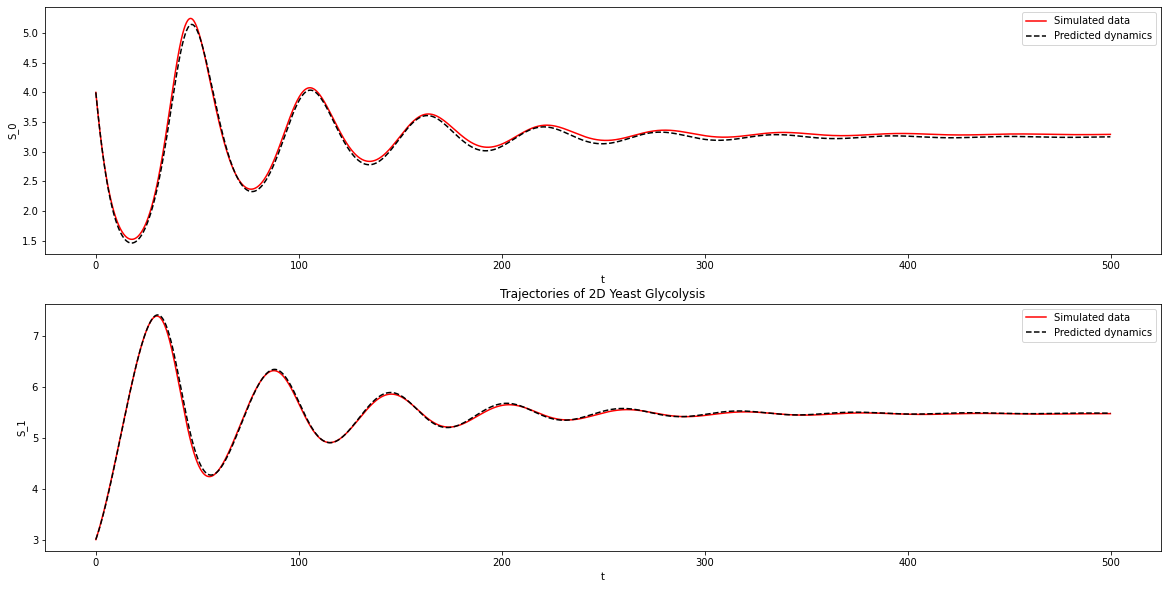

In [25]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

We see that the Multistep Neural Network is able to almost perfectly recover the dynamics of both species.